### Тестовое задание:

Задача прогноза отказа мотора на основе показаний датчиков.

Описание данных (архив во вложении):
   * id -- идентификатор мотора
   * cycle -- цикл работы
   * p00-p20 -- показания датчиков считываемые в процессе работы
   * s0, s1 -- настройки изменяемые в конце каждого цикла


Необходимо предложить решение задачи прогнозирования отказа моторов и варианты использования этого решения на практике.
Считаем, что максимальный цикл мотора в данных -- это последний цикл перед поломкой.
Базовый вариант – прогноз поломки на следующем цикле.
Решение в jupyter ноутбуке с необходимыми пояснениями/комментариями/графиками/расчетами и т.д. по ходу разработки. 

In [839]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from pylab import rcParams
import math
import xgboost
import time
from tqdm import tqdm

In [833]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

data = pd.read_csv('data.csv')
data.head(20)

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002
5,1,6,518.67,1.3,47.16,521.68,2388.03,8132.85,8.4108,0.03,391,2388,100,642.10,38.98,23.3669,1584.47,1398.37,14.62,21.61,554.67,2388.02,9049.68,-0.0043,-0.0001
6,1,7,518.67,1.3,47.36,522.32,2388.03,8132.32,8.3974,0.03,392,2388,100,642.48,39.10,23.3774,1592.32,1397.77,14.62,21.61,554.34,2388.02,9059.13,0.0010,0.0001
7,1,8,518.67,1.3,47.24,522.47,2388.03,8131.07,8.4076,0.03,391,2388,100,642.56,38.97,23.3106,1582.96,1400.97,14.62,21.61,553.85,2388.00,9040.80,-0.0034,0.0003
8,1,9,518.67,1.3,47.29,521.79,2388.05,8125.69,8.3728,0.03,392,2388,100,642.12,39.05,23.4066,1590.98,1394.80,14.62,21.61,553.69,2388.05,9046.46,0.0008,0.0001
9,1,10,518.67,1.3,47.03,521.79,2388.06,8129.38,8.4286,0.03,393,2388,100,641.71,38.95,23.4694,1591.24,1400.46,14.62,21.61,553.59,2388.05,9051.70,-0.0033,0.0001


## 1. Эксплораторный анализ

In [3]:
#Вынесем P-параметры и S-параметры в отдельные списки для удобства

parameters = ['p01', 'p02', 'p03', 'p04', 'p05', 'p06', 'p07', 'p08', 'p09', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16', 'p17', 'p18', 'p19', 'p20']

s_parameters = ['s1', 's2']

##### Посмотрим на моторы и их циклы работы


In [4]:
#количество моторов
data.id.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80])

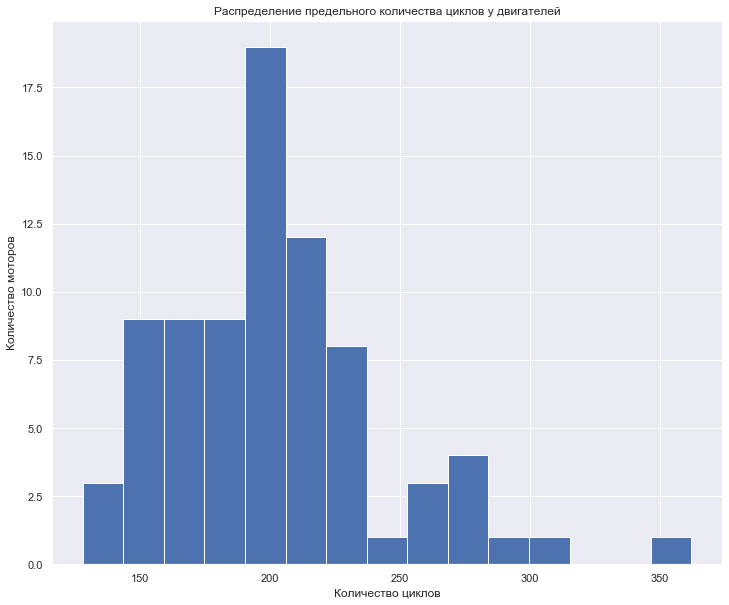

In [299]:
#Посмотрим на распределение по количеству циклов у моторов
engines_cycles = data[['id', 'cycle']].groupby('id').max().reset_index()
engines_cycles['cycle'].hist(bins=15)
plt.xlabel('Количество циклов')
plt.ylabel('Количество моторов')
plt.title('Распределение предельного количества циклов у двигателей')
plt.show()

Как можем видеть:
* мода количества циклов у моторов составляет порядка 200 циклов. 
* Распределение смещенно вправо
* Есть одно выбросное значение с 350 циклами

##### Проанализируем P-параметры


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16138 entries, 0 to 16137
Data columns (total 25 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      16138 non-null  int64  
 1   cycle   16138 non-null  int64  
 2   p00     16138 non-null  float64
 3   p01     16138 non-null  float64
 4   p02     16138 non-null  float64
 5   p03     16138 non-null  float64
 6   p04     16138 non-null  float64
 7   p05     16138 non-null  float64
 8   p06     16138 non-null  float64
 9   p07     16138 non-null  float64
 10  p08     16138 non-null  int64  
 11  p09     16138 non-null  int64  
 12  p10     16138 non-null  int64  
 13  p11     16138 non-null  float64
 14  p12     16138 non-null  float64
 15  p13     16138 non-null  float64
 16  p14     16138 non-null  float64
 17  p15     16138 non-null  float64
 18  p16     16138 non-null  float64
 19  p17     16138 non-null  float64
 20  p18     16138 non-null  float64
 21  p19     16138 non-null  float64
 22

Как можем видеть в данных нет пустых значений, но давайте более внимательно посмотрим на стаднартное октлонение, а также минимальные, максимальные, медианные,  и прочие значения датчиков на предмет выбросов


In [9]:
data[parameters].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p01,16138.0,1.300000,3.932532e-13,1.3000,1.3000,1.3000,1.3000,1.3000
p02,16138.0,47.544263,2.674218e-01,46.8600,47.3500,47.5200,47.7100,48.5300
p03,16138.0,521.405420,7.382523e-01,518.6900,520.9400,521.4600,521.9400,523.3800
p04,16138.0,2388.096737,7.260372e-02,2387.8800,2388.0400,2388.0900,2388.1400,2388.5600
p05,16138.0,8143.933458,1.973135e+01,8099.9400,8132.8300,8140.7500,8148.8175,8293.7200
p06,16138.0,8.442581,3.751962e-02,8.3249,8.4153,8.4398,8.4660,8.5848
p07,16138.0,0.030000,1.230304e-14,0.0300,0.0300,0.0300,0.0300,0.0300
p08,16138.0,393.227104,1.549031e+00,388.0000,392.0000,393.0000,394.0000,399.0000
p09,16138.0,2388.000000,0.000000e+00,2388.0000,2388.0000,2388.0000,2388.0000,2388.0000
p10,16138.0,100.000000,0.000000e+00,100.0000,100.0000,100.0000,100.0000,100.0000


Можем увидеть, что:
* параметры p09, p10 имеют стандартное отклонение равное 0. То есть они не меняются и соответственно ни на что не влияют
* параметры p01, p07, p16 и p17 также имеют минимальное отклонение, но к ним надо еще присмотреться
* в свою очередь параметры p05 и p20 имеют наибольшие отклонение, но о степени их влияния пока тоже рано что либо говорить


##### Проанализируем таким же образом S-параметры


In [10]:
data[s_parameters].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s1,16138.0,9.988846e-06,0.002188,-0.0086,-0.0014,0.0,0.0015,0.0087
s2,16138.0,6.196555e-08,0.000294,-0.0006,-0.0003,0.0,0.0003,0.0006


Какие либо аномалии в значениях обнаружены не были


#### Визуализация P-параметров

In [510]:
# У нас есть данные для 80 двигателей, но мы не можем потсроить графики для них всех, 
# так как тогда будет слишком большая плотность графиок и ничего не будет видно
# Поэтому попробуем взять выборку из 10 двигателей
engine_id = [1, 10, 20, 30, 40, 50, 60, 70, 80]

# Напишем функцию для построения графиков исходя из выбранного параметра, где на плоскости Х у нас будут количество циклов двигателя
def graph_parameter(parameter_name):
    plt.figure(figsize=(10,5))
    
    for i in engine_id:
        engine = data[data.id == i]
        plt.plot(engine['cycle'], engine[parameter_name])
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(parameter_name)
    plt.xlabel('Цикл')
    plt.title('Значение датчика ' + parameter_name)
    plt.show()

#### Визуализация параметра с наименьшим отклонением (p09, p10 )

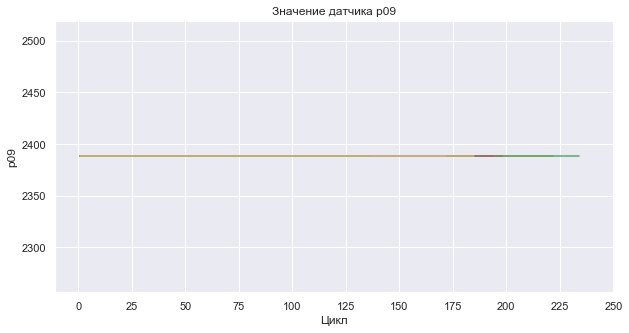

In [354]:
# Как упоминалось выше у параметра p09 отклонение равно 0 и поэтому мы ожидаем получить просто прямую горизонтальную линию.
# Соответственно у p10 будет то же самое 
graph_parameter('p09')

#### Визуализация параметров с наиболльшим отклонением (p05 и p20)


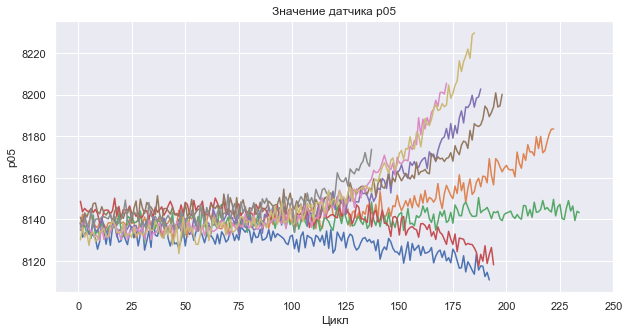

In [355]:
graph_parameter('p05')

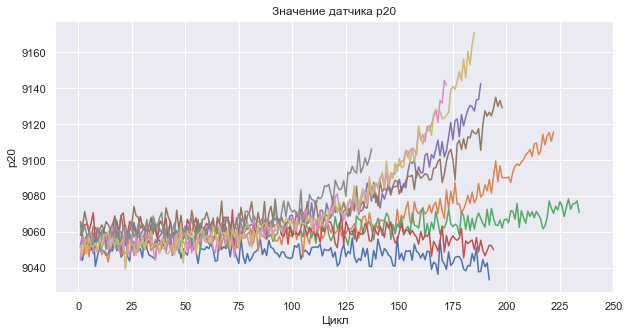

In [356]:
# На этих графиках наглядно видно, что наши дивгатели в целом стабильно работают до 120 циклов, 
# после чего начинаются отклонения в работе
graph_parameter('p20')

#### Визуализация других параметров


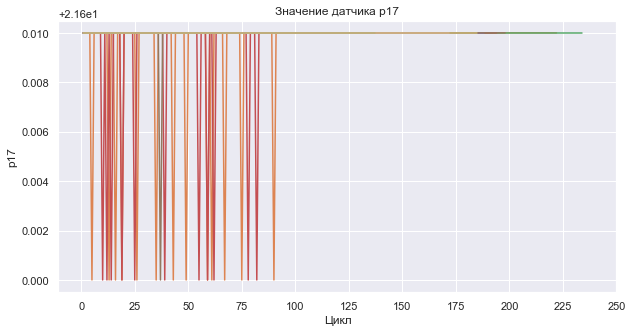

In [357]:
# Для сравнения видно, что параметр p17 иногда делает резкое пике вниз, но нему сложно что либо сказать
graph_parameter('p17')

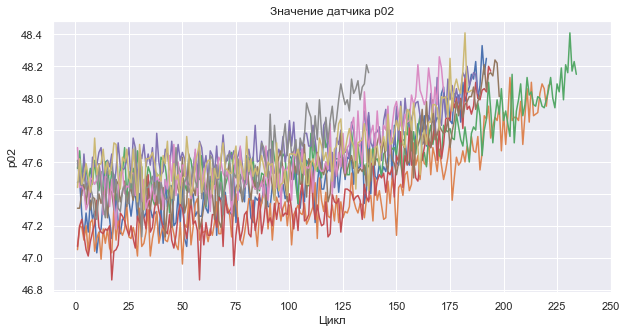

In [358]:
# А ряд парметров имеют четкий тренд на увеличение или уменьшение. 
# Но при этом сложно увидеть четкую связь между изменеием этих парметров и количеством циклов работы двигателей
graph_parameter('p02')

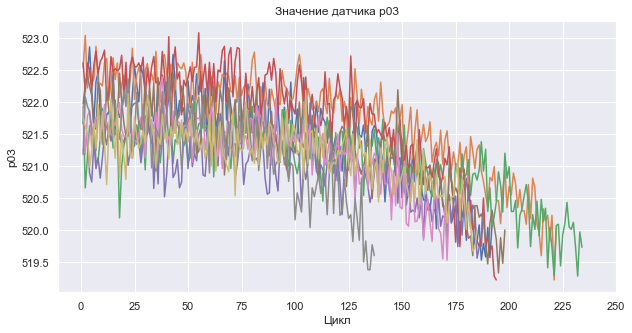

In [359]:
graph_parameter('p03')

### Поскольку целью данного задания является построить модель, которая будет предсказывать количество циклов, которое осталось у двигателя, то надо взять параметре "cycle" и на его основе подготовить новый признак "Remaining cycles", показывающий количество циклов до отказа

In [280]:
index_names = ['id', 'cycle']

def cycles_to_failure(df):
    grouped_by_unit = data.groupby(by="id")
    max_cycle = grouped_by_unit["cycle"].max()
    
    # Добавляем "max_cycle" в наш датафрейм
    result_frame = data.merge(max_cycle.to_frame(name='max_cycle'), left_on='id', right_index=True)
    
    # Считаем сколько осталось циклов 
    remaining_cycles = result_frame["max_cycle"] - result_frame["cycle"]
    result_frame["Remaining cycles"] = remaining_cycles
    
    # Удаляем "max_cycle"
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame
  
data2 = cycles_to_failure(data)
data2.head()

,id,cycle,p00,p01,p02,p03,p04,p05,p06,p07,p08,p09,p10,p11,p12,p13,p14,p15,p16,p17,p18,p19,p20,s1,s2,Remaining cycles
0,1,1,518.67,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100,641.82,39.06,23.4190,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,-0.0007,-0.0004,191
1,1,2,518.67,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100,642.15,39.00,23.4236,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,0.0019,-0.0003,190
2,1,3,518.67,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100,642.35,38.95,23.3442,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,-0.0043,0.0003,189
3,1,4,518.67,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100,642.35,38.88,23.3739,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,0.0007,0.0000,188
4,1,5,518.67,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100,642.37,38.90,23.4044,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,-0.0019,-0.0002,187


### Отобразим взаимные корреляции признаков на "тепловой карте"

In [281]:
# Но сначала также удалим параметры P09 и P10 так как мы выяснили ранее, что они не несут полезной информации

data2.drop(columns=['p09', 'p10'],inplace=True)


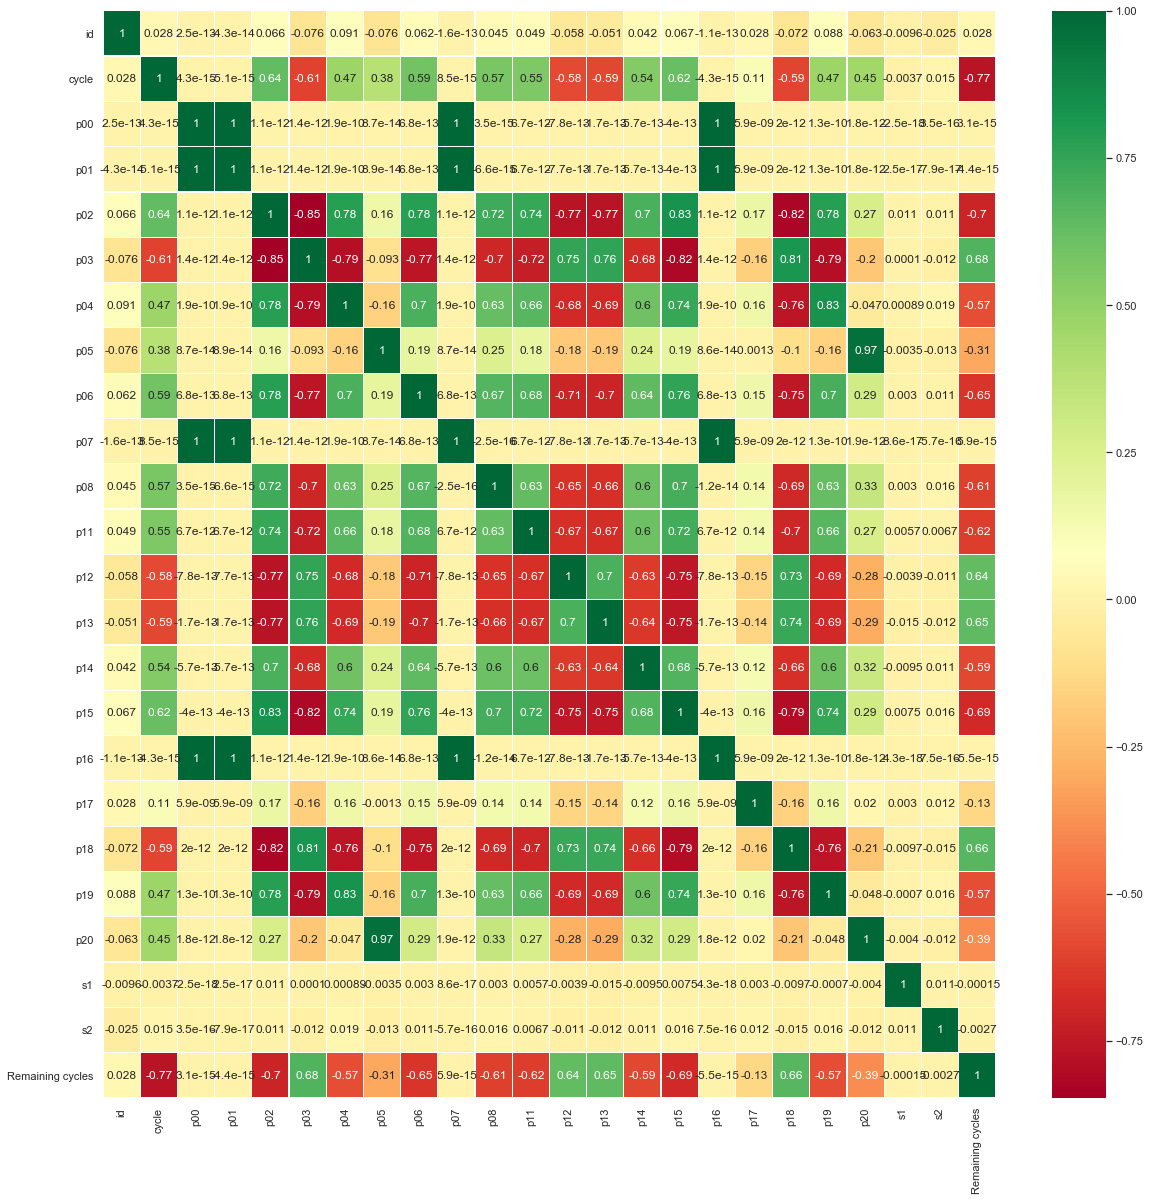

In [282]:
sns.heatmap(data2.corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,20)
plt.show()

### Удалим свойства, слабо коррелирующие с целевым показателем "Remaining cycles": p00, p01, p07, p16, cycle, s1 и s2. А также удалим однин из признаков, в сильной корреляции между собой (p05 и p20 имеют коэффициент корреляции 0.97, удалим p20)



In [283]:
data2 = data2.drop(columns = ['cycle','p00','p01','p07','p16', 'p20', 's1', 's2'])
data2.head(10)

,id,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,Remaining cycles
0,1,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,21.61,554.36,2388.06,191
1,1,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,21.61,553.75,2388.04,190
2,1,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,21.61,554.26,2388.08,189
3,1,47.13,522.86,2388.08,8133.83,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,21.61,554.45,2388.11,188
4,1,47.28,522.19,2388.04,8133.80,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,21.61,554.00,2388.06,187
5,1,47.16,521.68,2388.03,8132.85,8.4108,391,642.10,38.98,23.3669,1584.47,1398.37,21.61,554.67,2388.02,186
6,1,47.36,522.32,2388.03,8132.32,8.3974,392,642.48,39.10,23.3774,1592.32,1397.77,21.61,554.34,2388.02,185
7,1,47.24,522.47,2388.03,8131.07,8.4076,391,642.56,38.97,23.3106,1582.96,1400.97,21.61,553.85,2388.00,184
8,1,47.29,521.79,2388.05,8125.69,8.3728,392,642.12,39.05,23.4066,1590.98,1394.80,21.61,553.69,2388.05,183
9,1,47.03,521.79,2388.06,8129.38,8.4286,393,641.71,38.95,23.4694,1591.24,1400.46,21.61,553.59,2388.05,182


### 2. Первичная базовая линейная модель


#### Напишем несколько функций, которые будем использовать для оценки качества моделей

In [291]:
# Функция для оценки модели
def score_func(y_true,y_pred):
    print(f' mean absolute error {round(mean_absolute_error(y_true,y_pred),2)}')
    print(f' root mean squared error {round(mean_squared_error(y_true,y_pred),2) ** 0.5}')
    print(f' R2 score {round(r2_score(y_true,y_pred),2)}')
    return

In [829]:
# функция для совместного отображения реальных и предсказанных значений
def plot_result(y_true,y_pred, model):
    rcParams['figure.figsize'] = 12,10
    plt.plot(y_pred)
    plt.plot(y_true)
    plt.tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False)
    plt.ylabel('Сколько осталось циклов работы двигателя')
    plt.legend(('Predicted', 'True'), loc='upper right')
    plt.title('Сравнение реальных и предсказанных значений ' + model)
    plt.show()
    return

#### Подготовка тестовых и тренировочных данных

In [322]:
# В нашей выборке 80 двигателей.
# В тренировочные данные войдут первые 70 двигателей (~90%), остальные будем использовать при тестировании
train_ = data2[data2['id'] <= 70]

In [323]:
# Выделим параметры для X
X_train = train_.iloc[:,1:15]
X_train.head()

,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19
0,47.47,521.66,2388.02,8138.62,8.4195,392,641.82,39.06,23.4190,1589.70,1400.60,21.61,554.36,2388.06
1,47.49,522.28,2388.07,8131.49,8.4318,392,642.15,39.00,23.4236,1591.82,1403.14,21.61,553.75,2388.04
2,47.27,522.42,2388.03,8133.23,8.4178,390,642.35,38.95,23.3442,1587.99,1404.20,21.61,554.26,2388.08
3,47.13,522.86,2388.08,8133.83,8.3682,392,642.35,38.88,23.3739,1582.79,1401.87,21.61,554.45,2388.11
4,47.28,522.19,2388.04,8133.80,8.4294,393,642.37,38.90,23.4044,1582.85,1406.22,21.61,554.00,2388.06


In [324]:
# Выделим целевую переменную для Y
y_train = train_.iloc[:,15]
y_train.head()

0    191
1    190
2    189
3    188
4    187
Name: Remaining cycles, dtype: int64

In [325]:
# Создадим тестовую выборку
test_ = data2[data2['id'] > 70]

In [327]:
#Сделаем из тестового датасета семплированием выборку из 100 строк для дальнейшей оценки алгоритма
test_ = test_.sample(n=100, random_state = 45)

In [328]:
test_.head()

,id,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,Remaining cycles
14698,73,47.65,520.93,2388.19,8121.56,8.4801,393,643.12,38.82,23.1505,1598.12,1422.58,21.61,553.18,2388.18,65
14342,72,47.48,522.12,2388.05,8126.61,8.3926,393,642.87,38.86,23.4376,1583.99,1400.95,21.61,554.53,2388.06,208
14169,71,47.38,521.60,2388.15,8125.29,8.4088,393,642.46,38.88,23.3635,1590.25,1414.42,21.61,553.71,2388.15,168
14139,71,47.53,521.19,2388.10,8123.07,8.4249,392,642.95,38.95,23.3315,1593.60,1405.47,21.61,553.50,2388.10,198
15883,79,47.39,521.93,2388.03,8147.28,8.4430,392,642.51,38.90,23.3328,1582.33,1410.22,21.61,554.11,2388.14,69


In [329]:
X_test =  test_.iloc[:,1:15]
y_test =  test_.iloc[:,15]

#### Базовая линейная модель

In [330]:
lm = LinearRegression()
lm.fit(X_train, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [331]:
y_pred = lm.predict(X_test)
score_func(y_test, y_pred)

 mean absolute error 31.46
 root mean squared error 38.51752847730498
 R2 score 0.55


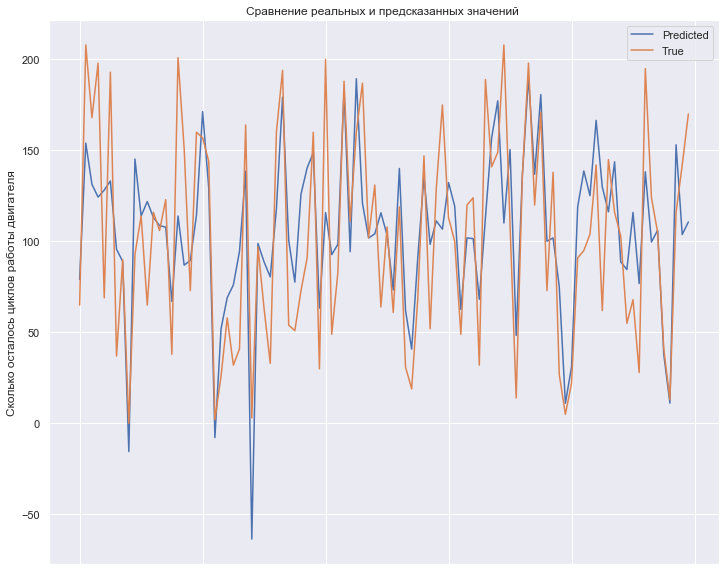

In [332]:
plot_result(y_test.to_numpy(),y_pred)

Результат работы модели оставляет желать лучшего, но это стартовая точка. 

В следующих шагах мы:
* попробуем сгенерировать новые признакми и посмотрим как они улучшат качество моделей
* попробуем использовать другие модели
* попробуем подобрать более оптимальные параметры моделей 



## 3. Feature Engineering

### 3.1 Смещение стартовой точки регрессии

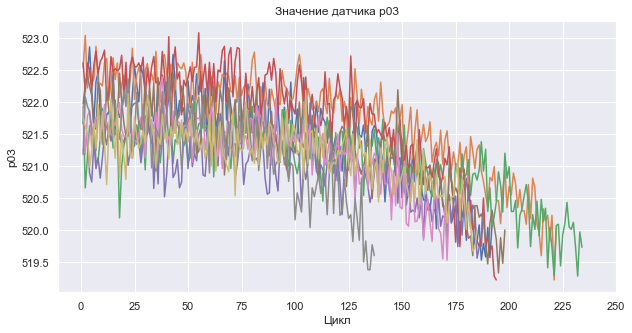

In [361]:
graph_parameter('p03')

Как мы видели выше двигатели в целом стабильно работают примерно первые 100 циклов, после чего значения параметров перестают быть стабильным (см. график значений датчика p03 выше). То есть на самом деле значения датчиков имеют график экспоненты и строить линейную регрессию в данном случае некорретно.


In [371]:
# Здесь мы видим, что самое меньшее число рабочих циклов у двигателя составило 128 циклов. 
grouped = data.groupby('id').cycle.count().reset_index()
grouped.cycle.min()

128

Однако мы можем убрать из нашей выборки значения датчиков до 120 циклов работы двигателя. И посмотреть как это отразится на качестве модели

In [455]:
data3 = cycles_to_failure(data)
data3 = data3[data3['cycle'] >= 120]
data3.drop(columns=['p09', 'p10'],inplace=True)
data3 = data3.drop(columns = ['cycle','p00','p01','p07','p16', 'p20', 's1', 's2'])

train_ = data3[data3['id'] <= 70]
X_train = train_.iloc[:,1:15]
y_train = train_.iloc[:,15]

test_ = data3[data3['id'] > 70]
test_ = test_.sample(n=100, random_state = 45)
X_test =  test_.iloc[:,1:15]
y_test =  test_.iloc[:,15]

In [378]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [379]:
y_pred = lm.predict(X_test)
score_func(y_test, y_pred)

 mean absolute error 11.22
 root mean squared error 15.096357176484664
 R2 score 0.71


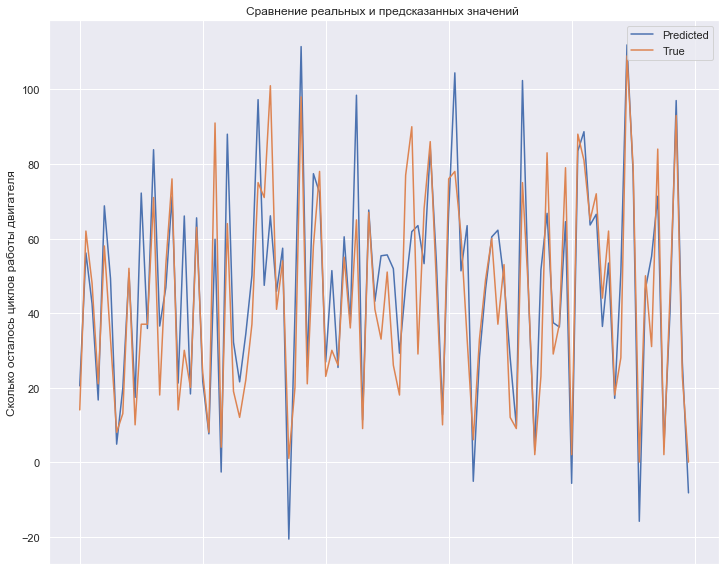

In [380]:
plot_result(y_test.to_numpy(),y_pred)

Мы видимо, что качество модели резко вырасло.

### 3.2 Добавление скользящего среднего как нового признака

In [651]:

parameters = ['p02', 'p03', 'p04', 'p05', 'p06', 'p08', 'p11', 'p12', 'p13', 'p14', 'p15', 'p17', 'p18', 'p19']

# Напишем функцию, которая будет добавлять скользящее среднее n строк для подаваемых параметров как новый признак
def moving_average(dataframe, parameter_list, n=5):
    for parameter in parameter_list:
        dataframe['rolling ' + parameter] = dataframe[parameter].rolling(n).mean()

data4 = data3

data4 = data4.dropna()
data4.head()

,id,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,Remaining cycles,rolling p02,rolling p03,rolling p04,rolling p05,rolling p06,rolling p08,rolling p11,rolling p12,rolling p13,rolling p14,rolling p15,rolling p17,rolling p18,rolling p19
123,1,47.55,521.40,2388.13,8133.82,8.4416,393,642.48,38.80,23.2341,1587.14,1402.28,21.61,552.26,2388.13,68,47.520,521.312,2388.112,8130.972,8.42720,393.0,642.922,38.800,23.30670,1590.964,1407.774,21.61,553.138,2388.114
124,1,47.63,521.57,2388.11,8126.33,8.4079,394,642.96,38.68,23.3039,1585.47,1406.42,21.61,552.44,2388.13,67,47.526,521.358,2388.114,8131.124,8.42820,393.2,642.952,38.774,23.30626,1589.302,1407.522,21.61,552.894,2388.120
125,1,47.49,521.35,2388.08,8130.94,8.4378,392,642.49,38.85,23.2289,1582.64,1418.50,21.61,553.72,2388.05,66,47.536,521.368,2388.122,8130.524,8.43050,392.8,642.924,38.818,23.26764,1587.118,1408.842,21.61,552.898,2388.116
126,1,47.63,521.34,2388.10,8133.00,8.4626,393,642.99,38.91,23.2772,1586.90,1399.49,21.61,553.81,2388.09,65,47.542,521.452,2388.118,8130.762,8.43790,392.8,642.862,38.828,23.26722,1585.762,1405.946,21.61,552.974,2388.104
127,1,47.62,521.96,2388.16,8132.08,8.4413,393,642.47,38.85,23.2641,1593.87,1407.06,21.61,552.74,2388.13,64,47.584,521.524,2388.116,8131.234,8.43824,393.0,642.678,38.818,23.26164,1587.204,1406.750,21.61,552.994,2388.106


In [431]:
train_ = data4[data4['id'] <= 70]
X_train = train_.drop(columns = ['id','Remaining cycles'])
y_train = train_['Remaining cycles']

test_ = data4[data4['id'] > 70]
test_ = test_.sample(n=100, random_state = 45)
X_test = test_.drop(columns = ['id','Remaining cycles'])
y_test =  test_['Remaining cycles']

In [435]:

lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [436]:
y_pred = lm.predict(X_test)
score_func(y_test, y_pred)

 mean absolute error 11.41
 root mean squared error 15.439883419248993
 R2 score 0.7


Качество немного понизилось, но эти признаки мы оставим и посмотрим как они отразаться на качестве в других моделях

### 3.3 Добавим признак "среднее значение параметров в разрезе оставшихся циклов" 

In [655]:
data5 = data4

parameters = ['p02', 'p03', 'p04', 'p05', 'p06', 'p08', 'p11', 'p12', 'p13', 'p14', 'p15', 'p17', 'p18', 'p19']

# Напишем функцию, которая будет считать среднее значение параметров p** в разрезе оставшихся циклов двигателей
# То есть мы возьмем все значения p02 когда у двигателей остался всего 1 цикл работы и найдем среднее значение.
# Затем все значения p02 когда у двигателей осталось 2 цикла работы и найдем среднее значение и так далее для всех циклов
# После сделаем такой же расчет для каждого другого параметра p**

def mean_value(row, parameter, dataframe):
    values = []
    value_for_range = dataframe['Remaining cycles'].max()
    for i in range(0, value_for_range + 1): 
        df = dataframe[dataframe['Remaining cycles'] == i]
        parameter_value = df[parameter].mean()
        values.append(parameter_value)
        if row['Remaining cycles'] == i:
            return values[i]

for parameter in parameters:    
    data5['mean of ' + parameter] = data5.apply (lambda row: mean_value(row, parameter, data5), axis=1)


In [653]:
data5.head()

,id,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,Remaining cycles,rolling p02,rolling p03,rolling p04,rolling p05,rolling p06,rolling p08,rolling p11,rolling p12,rolling p13,rolling p14,rolling p15,rolling p17,rolling p18,rolling p19,mean of p02,mean of p03,mean of p04,mean of p05,mean of p06,mean of p08,mean of p11,mean of p12,mean of p13,mean of p14,mean of p15,mean of p17,mean of p18,mean of p19
123,1,47.55,521.40,2388.13,8133.82,8.4416,393,642.48,38.80,23.2341,1587.14,1402.28,21.61,552.26,2388.13,68,47.520,521.312,2388.112,8130.972,8.42720,393.0,642.922,38.800,23.30670,1590.964,1407.774,21.61,553.138,2388.114,47.588868,521.383774,2388.101509,8145.568679,8.446496,393.452830,642.708302,38.806226,23.272428,1591.173396,1409.971509,21.610000,553.217547,2388.097547
124,1,47.63,521.57,2388.11,8126.33,8.4079,394,642.96,38.68,23.3039,1585.47,1406.42,21.61,552.44,2388.13,67,47.526,521.358,2388.114,8131.124,8.42820,393.2,642.952,38.774,23.30626,1589.302,1407.522,21.61,552.894,2388.120,47.590377,521.291509,2388.103774,8145.504906,8.445068,393.320755,642.737358,38.781698,23.273147,1591.026226,1409.827736,21.609811,553.127736,2388.100189
125,1,47.49,521.35,2388.08,8130.94,8.4378,392,642.49,38.85,23.2289,1582.64,1418.50,21.61,553.72,2388.05,66,47.536,521.368,2388.122,8130.524,8.43050,392.8,642.924,38.818,23.26764,1587.118,1408.842,21.61,552.898,2388.116,47.584340,521.300000,2388.098302,8146.178679,8.446883,393.226415,642.714151,38.793774,23.285362,1591.803019,1410.691321,21.610000,553.224906,2388.102075
126,1,47.63,521.34,2388.10,8133.00,8.4626,393,642.99,38.91,23.2772,1586.90,1399.49,21.61,553.81,2388.09,65,47.542,521.452,2388.118,8130.762,8.43790,392.8,642.862,38.828,23.26722,1585.762,1405.946,21.61,552.974,2388.104,47.550364,521.318909,2388.098000,8146.342727,8.446600,393.509091,642.749636,38.801818,23.281284,1591.258182,1410.376545,21.610000,553.329818,2388.100182
127,1,47.62,521.96,2388.16,8132.08,8.4413,393,642.47,38.85,23.2641,1593.87,1407.06,21.61,552.74,2388.13,64,47.584,521.524,2388.116,8131.234,8.43824,393.0,642.678,38.818,23.26164,1587.204,1406.750,21.61,552.994,2388.106,47.588727,521.227818,2388.104364,8146.645818,8.444762,393.490909,642.743636,38.802000,23.268084,1590.996727,1409.086364,21.610000,553.203455,2388.107636


In [825]:
train_ = data5[data5['id'] <= 70]
X_train = train_.drop(columns = ['id','Remaining cycles'])
y_train = train_['Remaining cycles']

test_ = data5[data5['id'] > 70]
test_ = test_.sample(n=100, random_state = 45)
X_test = test_.drop(columns = ['id','Remaining cycles'])
y_test =  test_['Remaining cycles']

In [657]:
#Протестируем полученные признаки на нашей линейной моделе
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [658]:
y_pred = lm.predict(X_test)
score_func(y_test, y_pred)

 mean absolute error 6.58
 root mean squared error 7.939143530633515
 R2 score 0.92


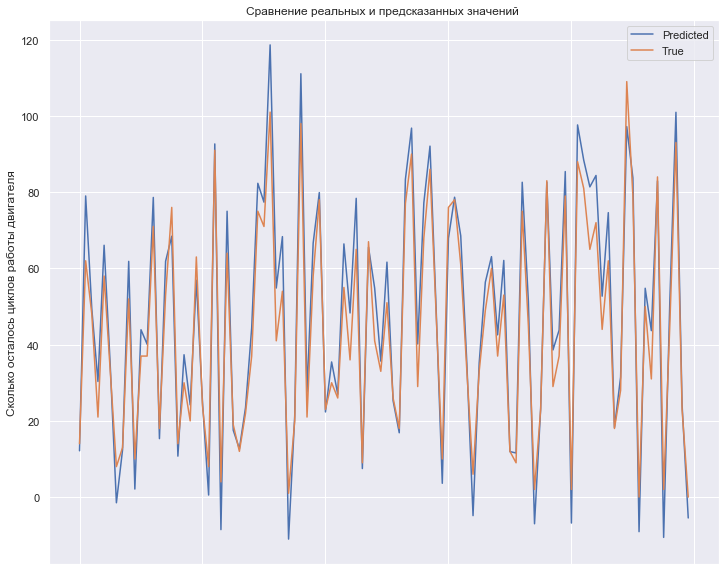

In [659]:
plot_result(y_test.to_numpy(),y_pred)

Мы видим, что были получены весьма неплохие показатели

# 4. Построение модели регрессии

#### Функция моделей "LinearRegression", "Random forest" и "XGBoost"

In [677]:
# Напишем одну функцию для создания и тренировки моделей по алгоритмам "LinearRegression", "Random forest" и "XGBoost"

def train_models(X, y, model = 'MLM'):
    
    if model == 'MLM':
        model = LinearRegression()

        model.fit(X, y)
        return model
    
    elif model == 'FOREST':
        model = RandomForestRegressor(n_estimators=70, max_features=7, max_depth=5, n_jobs=-1, random_state=1)
        model.fit(X, y)
        return model
    
    elif model == 'XGB':
        model = xgboost.XGBRegressor(n_estimators=110, learning_rate=0.018, gamma=0, subsample=0.8,
                           colsample_bytree=0.5, max_depth=3,silent=True)
        model.fit(X, y)
        return model
    return
    

### MLM

In [685]:
# Первоначальные тестовые и тренировочные данные
initial_train_ = data2[data2['id'] <= 70]
initial_X_train = train_.iloc[:,1:15]
initial_y_train = train_.iloc[:,15]

initial_test_ = data2[data2['id'] > 70]
initial_test_ = test_.sample(n=100, random_state = 45)
initial_X_test =  test_.iloc[:,1:15]
initial_y_test =  test_.iloc[:,15]

In [686]:
# Мы уже строили линейную модель, но снова взглянем какие были показатели до того как были добавлены новые признаки и как они изменились
mlm_without_FE = train_models(initial_X_train, initial_y_train, model = 'MLM')
initial_y_pred = mlm_without_FE.predict(initial_X_test)



In [687]:
mlm_with_new_features = train_models(X_train,y_train, model = 'MLM')
y_pred = mlm_with_new_features.predict(X_test)


In [689]:
print("Результаты модели MLM на первичных данных")
score_func(initial_y_test, initial_y_pred)
print("Результаты модели MLM на данных с новыми признаками")
score_func(y_test, y_pred)

Результаты модели MLM на первичных данных
 mean absolute error 11.22
 root mean squared error 15.098344280085813
 R2 score 0.71
Результаты модели MLM на данных с новыми признаками
 mean absolute error 6.58
 root mean squared error 7.939143530633515
 R2 score 0.92


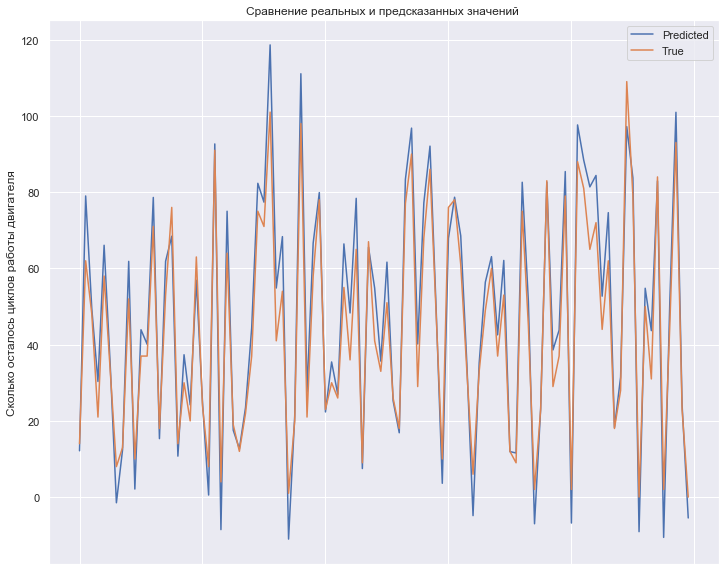

In [690]:
plot_result(y_test.to_numpy(),y_pred)

### Random forest

In [826]:
random_forest_without_FE = train_models(initial_X_train, initial_y_train, model = 'FOREST')
initial_y_pred = random_forest_without_FE.predict(initial_X_test)


In [827]:
Random_forest_with_features = train_models(X_train,y_train, model = 'FOREST')
y_pred = Random_forest_with_features.predict(X_test)

In [823]:
print("Результаты модели Random forest на первичных данных")
score_func(initial_y_test, initial_y_pred)
print("Результаты модели Random forest на данных с новыми признаками")
score_func(y_test, y_pred)

Результаты модели Random forest на первичных данных
 mean absolute error 13.36
 root mean squared error 17.84208507994511
 R2 score 0.59
Результаты модели Random forest на данных с новыми признаками
 mean absolute error 0.0
 root mean squared error 0.0
 R2 score 1.0


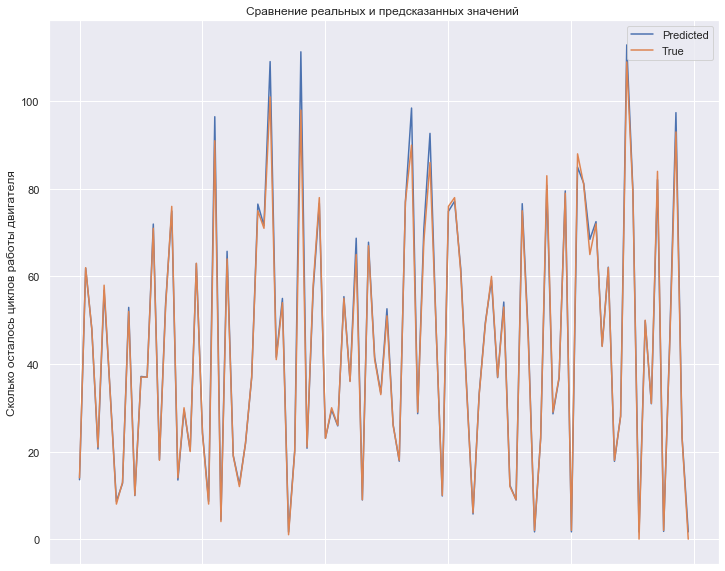

In [694]:
plot_result(y_test.to_numpy(),y_pred)

### XGBoost

In [695]:
XGB_without_FE = train_models(initial_X_train, initial_y_train, model = 'XGB')
initial_y_pred = XGB_without_FE.predict(initial_X_test)


In [696]:
XGB_with_features = train_models(X_train,y_train, model = 'XGB')
y_pred = XGB_with_features.predict(X_test)

In [697]:
print("Результаты модели XGBoost на первичных данных")
score_func(initial_y_test, initial_y_pred)
print("Результаты модели XGBoost на данных с новыми признаками")
score_func(y_test, y_pred)

Результаты модели XGBoost на первичных данных
 mean absolute error 13.22
 root mean squared error 17.39022714055225
 R2 score 0.61
Результаты модели XGBoost на данных с новыми признаками
 mean absolute error 5.5
 root mean squared error 6.343500610861483
 R2 score 0.95


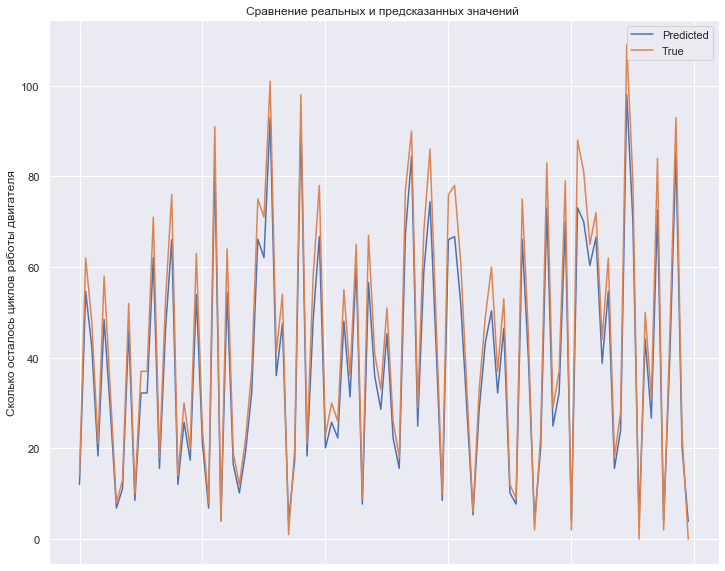

In [698]:
plot_result(y_test.to_numpy(),y_pred)

## Итог: как можно видеть из полученных метрик построенная модель Random forest дает самый лучший результат из трех моделей и имеет показатель R2 равный 1.0

# 5. Решение с помощью классификации

Подойдем к решению данной задачи с другой стороны.  Создадим классификатор, который будет отвечать на вопрос: "Текущий ресурс двигателя больше или меньше 5 циклов?" (Предполагается, что это достаточное время для подготовки и начала технического обслуживания) и на основе этого создадим матрицу, по которой возможно будет расчитать потенциальные убытки и выгоду.

## Expected Value Calculation:
В книге "Data Science for Business", https://www.amazon.com/Data-Science-Business-Data-Analytic-Thinking/dp/1449361323 
приводится метод расчета Expected Value для оценки разных моделей классификации. В его основе лежит построение матрицы «затрат—выгоды» где учитывается выгода от своевременного ремонта (то есть корректная классификация истинно положительных значений) и затраты, связанные с некорректной классификацией (ложные положительные и ложные негативные значения).

Для корректных рассчетов нужна доменная экспертиза, но мы сделаем ряд допущений:

(TP) - выгода 300 000р: двигатели нуждаются в техосмотре и были правильно выбраны моделью

(TN) - выгода 0р: двигатели в рабочем состоянии и не были выбраны моделью

(FP) - расходы -200 000р: двигатели в рабочем состоянии, но были отправлены на техосмотр моделью (то есть направлены преждевременно)

(FN) - расходы -300 000р: двигатели, которые требуют ремонта не были выбраны моделью

In [840]:
# формирование целевой переменной label, TTF - время до поломки
TTF = 5

data_for_classification = data5

data_for_classification['label'] = np.where(data5['Remaining cycles'] <= TTF, 1, 0 )

data_for_classification.head()

,id,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,Remaining cycles,rolling p02,rolling p03,rolling p04,rolling p05,rolling p06,rolling p08,rolling p11,rolling p12,rolling p13,rolling p14,rolling p15,rolling p17,rolling p18,rolling p19,mean of p02,mean of p03,mean of p04,mean of p05,mean of p06,mean of p08,mean of p11,mean of p12,mean of p13,mean of p14,mean of p15,mean of p17,mean of p18,mean of p19,label
123,1,47.55,521.40,2388.13,8133.82,8.4416,393,642.48,38.80,23.2341,1587.14,1402.28,21.61,552.26,2388.13,68,47.520,521.312,2388.112,8130.972,8.42720,393.0,642.922,38.800,23.30670,1590.964,1407.774,21.61,553.138,2388.114,47.588868,521.383774,2388.101509,8145.568679,8.446496,393.452830,642.708302,38.806226,23.272428,1591.173396,1409.971509,21.610000,553.217547,2388.097547,0
124,1,47.63,521.57,2388.11,8126.33,8.4079,394,642.96,38.68,23.3039,1585.47,1406.42,21.61,552.44,2388.13,67,47.526,521.358,2388.114,8131.124,8.42820,393.2,642.952,38.774,23.30626,1589.302,1407.522,21.61,552.894,2388.120,47.590377,521.291509,2388.103774,8145.504906,8.445068,393.320755,642.737358,38.781698,23.273147,1591.026226,1409.827736,21.609811,553.127736,2388.100189,0
125,1,47.49,521.35,2388.08,8130.94,8.4378,392,642.49,38.85,23.2289,1582.64,1418.50,21.61,553.72,2388.05,66,47.536,521.368,2388.122,8130.524,8.43050,392.8,642.924,38.818,23.26764,1587.118,1408.842,21.61,552.898,2388.116,47.584340,521.300000,2388.098302,8146.178679,8.446883,393.226415,642.714151,38.793774,23.285362,1591.803019,1410.691321,21.610000,553.224906,2388.102075,0
126,1,47.63,521.34,2388.10,8133.00,8.4626,393,642.99,38.91,23.2772,1586.90,1399.49,21.61,553.81,2388.09,65,47.542,521.452,2388.118,8130.762,8.43790,392.8,642.862,38.828,23.26722,1585.762,1405.946,21.61,552.974,2388.104,47.550364,521.318909,2388.098000,8146.342727,8.446600,393.509091,642.749636,38.801818,23.281284,1591.258182,1410.376545,21.610000,553.329818,2388.100182,0
127,1,47.62,521.96,2388.16,8132.08,8.4413,393,642.47,38.85,23.2641,1593.87,1407.06,21.61,552.74,2388.13,64,47.584,521.524,2388.116,8131.234,8.43824,393.0,642.678,38.818,23.26164,1587.204,1406.750,21.61,552.994,2388.106,47.588727,521.227818,2388.104364,8146.645818,8.444762,393.490909,642.743636,38.802000,23.268084,1590.996727,1409.086364,21.610000,553.203455,2388.107636,0


### Попробуем визуализировать диаграмму рассеивания двух параметров с разделением по целевому признаку

Text(0.5, 1.0, 'Диаграмма рассеивания показаний p11 от показаний p05')

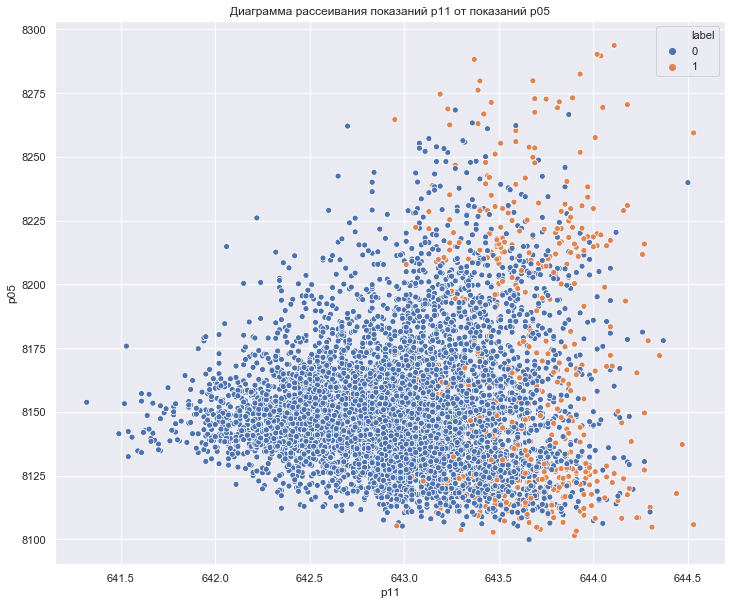

In [701]:
sns.scatterplot(x="p11", y="p05", hue="label", data=data_for_classification)
plt.title('Диаграмма рассеивания показаний p11 от показаний p05')

## Подготовим данные для классификации


In [795]:
#Был изменен порядок столбов в data_for_classification, так чтобы 'Remaining cycles' и "label" были в конце

X_class = data_for_classification.iloc[:,1:-2] # Выбираем все признаки кроме "id", 'Remaining cycles' и "label"

X_class.head()

,p02,p03,p04,p05,p06,p08,p11,p12,p13,p14,p15,p17,p18,p19,rolling p02,rolling p03,rolling p04,rolling p05,rolling p06,rolling p08,rolling p11,rolling p12,rolling p13,rolling p14,rolling p15,rolling p17,rolling p18,rolling p19,mean of p02,mean of p03,mean of p04,mean of p05,mean of p06,mean of p08,mean of p11,mean of p12,mean of p13,mean of p14,mean of p15,mean of p17,mean of p18,mean of p19
123,47.55,521.40,2388.13,8133.82,8.4416,393,642.48,38.80,23.2341,1587.14,1402.28,21.61,552.26,2388.13,47.520,521.312,2388.112,8130.972,8.42720,393.0,642.922,38.800,23.30670,1590.964,1407.774,21.61,553.138,2388.114,47.588868,521.383774,2388.101509,8145.568679,8.446496,393.452830,642.708302,38.806226,23.272428,1591.173396,1409.971509,21.610000,553.217547,2388.097547
124,47.63,521.57,2388.11,8126.33,8.4079,394,642.96,38.68,23.3039,1585.47,1406.42,21.61,552.44,2388.13,47.526,521.358,2388.114,8131.124,8.42820,393.2,642.952,38.774,23.30626,1589.302,1407.522,21.61,552.894,2388.120,47.590377,521.291509,2388.103774,8145.504906,8.445068,393.320755,642.737358,38.781698,23.273147,1591.026226,1409.827736,21.609811,553.127736,2388.100189
125,47.49,521.35,2388.08,8130.94,8.4378,392,642.49,38.85,23.2289,1582.64,1418.50,21.61,553.72,2388.05,47.536,521.368,2388.122,8130.524,8.43050,392.8,642.924,38.818,23.26764,1587.118,1408.842,21.61,552.898,2388.116,47.584340,521.300000,2388.098302,8146.178679,8.446883,393.226415,642.714151,38.793774,23.285362,1591.803019,1410.691321,21.610000,553.224906,2388.102075
126,47.63,521.34,2388.10,8133.00,8.4626,393,642.99,38.91,23.2772,1586.90,1399.49,21.61,553.81,2388.09,47.542,521.452,2388.118,8130.762,8.43790,392.8,642.862,38.828,23.26722,1585.762,1405.946,21.61,552.974,2388.104,47.550364,521.318909,2388.098000,8146.342727,8.446600,393.509091,642.749636,38.801818,23.281284,1591.258182,1410.376545,21.610000,553.329818,2388.100182
127,47.62,521.96,2388.16,8132.08,8.4413,393,642.47,38.85,23.2641,1593.87,1407.06,21.61,552.74,2388.13,47.584,521.524,2388.116,8131.234,8.43824,393.0,642.678,38.818,23.26164,1587.204,1406.750,21.61,552.994,2388.106,47.588727,521.227818,2388.104364,8146.645818,8.444762,393.490909,642.743636,38.802000,23.268084,1590.996727,1409.086364,21.610000,553.203455,2388.107636


In [796]:
Y_class = data_for_classification.iloc[:,-2:] # Выбираем признак "label" и "Remaining cycles"

Y_class.head()

,Remaining cycles,label
123,68,0
124,67,0
125,66,0
126,65,0
127,64,0


In [797]:
# Здесь делим данные на обучающую выборку и тестовую, задаем долю тестовой выборки = 20%

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X_class,Y_class,test_size = 0.2,random_state = 3)

In [798]:
# remaining_cycles вывели отдельно так как эти значения нам понадобяться для сводной таблицы позде
remaining_cycles = y_test.iloc[:,-2:-1] 
remaining_cycles = remaining_cycles.to_numpy()


X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

y_train = y_train.iloc[:,-1:].to_numpy() # Сюда отдельно вывели признак "label"
y_train = np.ravel(y_train)

y_test = y_test.iloc[:,-1:].to_numpy()
y_test = np.ravel(y_test)




In [835]:
#Импортируем модели
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier




In [836]:
# Обучаем LogisticRegression

# Сначала нормализуем данные для логистической регрессии
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

LR = LogisticRegression()
LR.fit(scaled_X_train, y_train)

/Users/Dmitry/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [837]:
# Обучаем RandomForestClassifier
forest = RandomForestClassifier(n_estimators=70 ,max_depth = 8, random_state=193)
forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=8, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=193,
                       verbose=0, warm_start=False)

In [838]:
# Обучаем XGBClassifier
model_xgb = XGBClassifier()
model_xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [841]:
#Импортируем метрики и напишем функцию, которую будем использовать для оценки модели

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def classificator_score(y_,y_p):
    print(f' accuracy score {round(accuracy_score(y_, y_p),2)}')
    print(f' precision score {round(precision_score(y_, y_p),2)}')
    print(f' recall score {round(recall_score(y_, y_p),2)}')
    print(f' F1 score {round(f1_score(y_, y_p),2)}')
    return

## Метрики для LogisticRegression

In [818]:
LR_predict = LR.predict(scaled_X_test)

classificator_score(y_test, LR_predict)

 accuracy score 1.0
 precision score 1.0
 recall score 1.0
 F1 score 1.0


## Метрики для RandomForestClassifier

In [807]:
forest_predict = forest.predict(X_test)

classificator_score(y_test, forest_predict)

 accuracy score 1.0
 precision score 1.0
 recall score 1.0
 F1 score 1.0


## Метрики для XGBClassifier

In [806]:
xgb_predict = model_xgb.predict(X_test)

classificator_score(y_test, xgb_predict)

 accuracy score 1.0
 precision score 1.0
 recall score 1.0
 F1 score 1.0


In [819]:
# Для построения матрицы «затрат—выгоды» необходимо сделать сводную таблицу с истинными метками и метками, 
# которые предсказывают модели 
# время до поломки = TTF = 5

TTF = 5

predicted = pd.DataFrame()
predicted ['Logistic Regression'] = LR_predict
predicted ['Forest'] = forest_predict
predicted['XGB'] = xgb_predict
predicted['Remaining cycles']= remaining_cycles
predicted['true_label'] = y_test
predicted['unit_number'] = predicted.index + 1

predicted.head(20)

,Logistic Regression,Forest,XGB,Remaining cycles,true_label,unit_number
0,0,0,0,128,0,1
1,0,0,0,64,0,2
2,0,0,0,218,0,3
3,0,0,0,65,0,4
4,0,0,0,67,0,5
5,0,0,0,69,0,6
6,0,0,0,29,0,7
7,0,0,0,111,0,8
8,1,1,1,0,1,9
9,0,0,0,45,0,10


In [731]:
# Напишем функция для вычисления ожидаемой прибыли, исходя из предположений, которые мы сделали выше


def expected_profit(y_true,y_pred):
    TP=0
    FP=0
    TN=0
    FN=0
    for i in range(len(y_true)):
        if (y_true[i] != y_pred[i]) & (y_pred[i] == 1):
            FP += 1
        elif (y_true[i] != y_pred[i]) & (y_pred[i] == 0):
            FN += 1
        elif (y_true[i] == y_pred[i]) & (y_pred[i] == 0):
            TN += 1
        else:
            TP += 1
    print(f'TP ={TP}, TN = {TN}, FP = {FP}, FN = {FN}')
    print (f'ожидаемая прибыль {(300 * TP - 200 * FN - 100 * FP) * 1000}')
    return 

In [820]:
#Расчет прибыли для модели LogisticRegression
expected_profit(y_test, LR_predict)

TP =72, TN = 1251, FP = 0, FN = 0
ожидаемая прибыль 21600000


In [812]:
#Расчет прибыли для модели RandomForestClassifier
expected_profit(y_test, forest_predict)

TP =72, TN = 1251, FP = 0, FN = 0
ожидаемая прибыль 21600000


In [811]:
#Расчет прибыли для модели XGBClassifier
expected_profit(y_test, xgb_predict)

TP =72, TN = 1251, FP = 0, FN = 0
ожидаемая прибыль 21600000


У всех трех моделей был F1 показатель равный 1.0 и поэтому показатели expected_profit ожидаемы были получены одинаковые

# 6. Выводы

В рамках данного тестового задания были:
* выявлены и сгенерированы дополнительные признаки, которые существенно улучшили показатели предиктивных моделей
* построены модели регрессии и модели классификаци

В процессе генерирования признаков было сделано допущение, что все двигатели будут работать минимум 120 циклов и поэтому данные модели строились на данных, полученных после того как двигатели отработали именно это количество циклов.

Среди моделей регрессии модель Random Forest показала себя лучше всего и получила значение R2 равное 1.0 на тестовых данных. Эта модель отлично подходит для оценки примерного оставшегося ресурса двигателя. 

Это позволяет делать более долгосрочное планирование об использовании двигателей, их модернизации или закупке новых. Как видно из графика ниже этот алгоритм в отдельных случаях может предсказать до 110 дополнительных циклов работы прежде чем двигатель выйдет из строя.



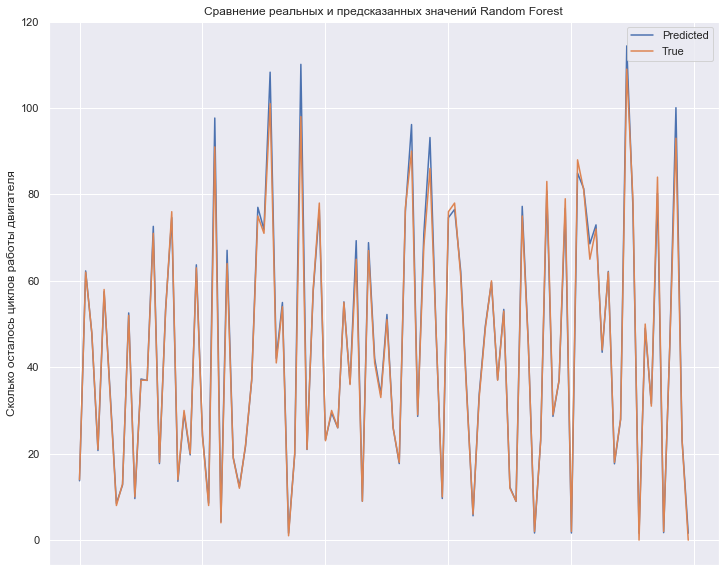

In [831]:
plot_result(y_test.to_numpy(),y_pred, 'Random Forest')

Среди алгоритмов классификации все три алгоритма дали 100% результат на тестовых данных и могут использоваться для получения экономии средств засчет:
* своевременного сигнализирования о необходимости провести технический осмотр (сейчас алгоритмы настроены на уведомление если осталось 5 рабочих циклов или менее), таким образом избегая простоя техники и упущенной выгоды
* сокращения расходов на ремонт техники, которая еще находится в рабочем состоянии



#### Спасибо за внимание